## Phase 4: Data Visualization

In [26]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum as _sum, round, col, when
import matplotlib.pyplot as plt
import seaborn as sns


In [27]:
spark = (
    SparkSession.builder
    .appName("DataVisualization")
    .config("spark.sql.shuffle.partitions", "80")               # Since 8 cores (2*4vCPU) , rule of thumb: 10 shuffle partitions per CPU core 
    .config("spark.executor.memory", "5g")                      # memory per executor (per node 10gb memory assigned to executor out of 15gb,giving room for overhead)
    .config("spark.driver.memory", "4g")                        # Adjust if driver needs more, can be increased to 6g
    .config("spark.executor.cores", "2")                        # Good parallelism, 4 executor across cluster which avoids overloading one executor
    .config("spark.dynamicAllocation.enabled", "true")          # Useful for Dataproc
    .getOrCreate()
)

25/05/25 06:30:55 INFO SparkEnv: Registering MapOutputTracker
25/05/25 06:30:55 INFO SparkEnv: Registering BlockManagerMaster
25/05/25 06:30:55 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
25/05/25 06:30:56 INFO SparkEnv: Registering OutputCommitCoordinator


In [28]:
# Path to file stored in processed layer
base_dir_path = 'gs://dataproc-staging-us-central1-784600309852-sdhxiysx/notebooks/jupyter/FEC Project/data/aggregated/2019-2020/'

# Read Data from parquet

# individual contributions per candidate
TotalIndivConPerCan_df = spark.read.parquet(base_dir_path + 'TotalIndivConPerCan_df')

# aggregated donations grouped by state
AggDonByState_df = spark.read.parquet(base_dir_path + 'AggDonByState_df')

# campaign expenditures grouped by month
TotExpPerMon_df = spark.read.parquet(base_dir_path + 'TotExpPerMon_df')

# individual donors by total amount and frequency
TopDonors_df = spark.read.parquet(base_dir_path + 'TopDonors_df')

# donation distribution by amount buckets
DonDist_df = spark.read.parquet(base_dir_path + 'DonDist_df')

### Total Individual Contributions By Candidate

In [29]:
# Convert to pandas df
TotalIndivConPerCan_pdf = TotalIndivConPerCan_df.toPandas()
TotalIndivConPerCan_pdf.head(10)

,CAND_ID,CAND_NAME,CAND_PTY_AFFILIATION,CAND_OFFICE,total_indiv_contributions,total_indiv_contributions_million
0,P80001571,"TRUMP, DONALD J.",REP,P,122027719.0,122.03
1,P80000722,"BIDEN, JOSEPH R JR",DEM,P,104819756.0,104.82
2,S8GA00180,"OSSOFF, T. JONATHAN",DEM,S,57978753.0,57.98
3,S0SC00149,"GRAHAM, LINDSEY O.",REP,S,49869329.0,49.87
4,S4GA11285,"PERDUE, DAVID",REP,S,46434053.0,46.43
5,S8AZ00221,"MCSALLY, MARTHA",REP,S,39870868.0,39.87
6,S0GA00526,"LOEFFLER, KELLY",REP,S,34336698.0,34.34
7,S0ME00111,"GIDEON, SARA",DEM,S,33104551.0,33.10
8,S0AZ00350,"KELLY, MARK",DEM,S,31943515.0,31.94
9,S0KY00339,"MCGRATH, AMY",DEM,S,28955458.0,28.96


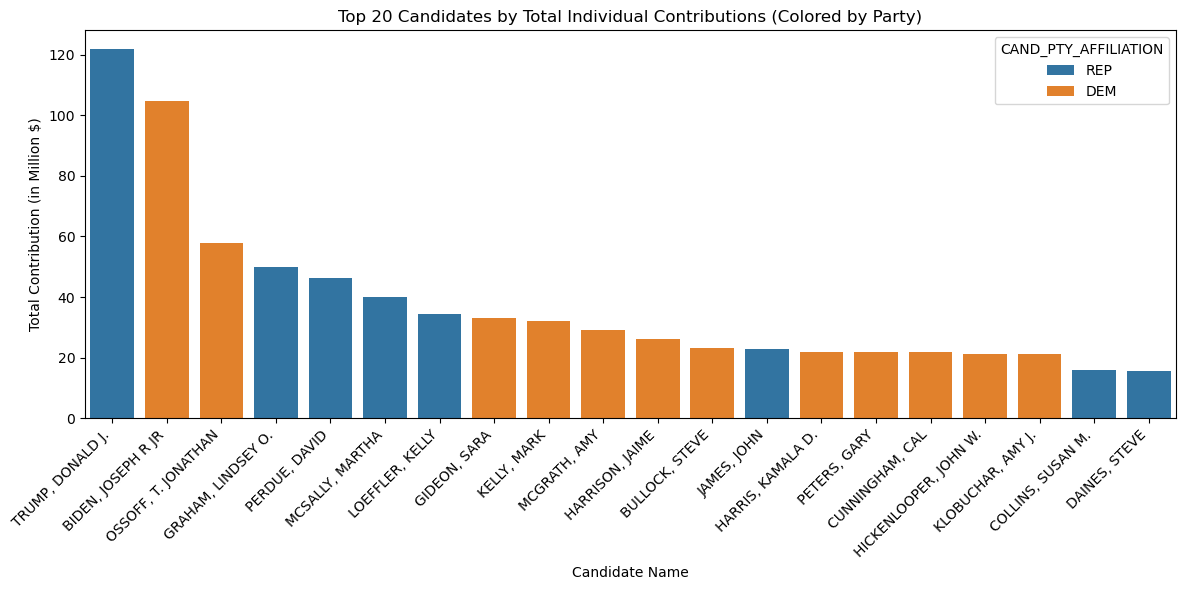

In [ ]:
# Plot
plt.figure(figsize=(12,6))
sns.barplot(
    data=TotalIndivConPerCan_pdf.head(20),
    x='CAND_NAME',
    y='total_indiv_contributions_million',
    hue='CAND_PTY_AFFILIATION'
    )

# Set axis labels and title
plt.xlabel('Candidate Name')
plt.ylabel('Total Contribution (in Million $)')
plt.title("Top 20 Candidates by Total Individual Contributions (Colored by Party)")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Contributions Share By Party (Republican, Democrat and Others)

In [31]:
# Add a new column to group parties
TotalIndivConPerCan_df_grouped = TotalIndivConPerCan_df.withColumn(
    "party_group",
    when(col("CAND_PTY_AFFILIATION") == "REP", "Republican")
    .when(col("CAND_PTY_AFFILIATION") == "DEM", "Democrat")
    .otherwise("Others")
)

# Combined contributions for all parties
TotalContributions = TotalIndivConPerCan_df_grouped.agg(_sum('total_indiv_contributions')).collect()[0][0]

# Calculating contributions by party and it's share by percentage
ConByParty_df = TotalIndivConPerCan_df_grouped.groupBy('party_group') \
                .agg(
    _sum(col('total_indiv_contributions')).alias('contr_by_party')
    )
ConByParty_df = ConByParty_df.withColumn('per_contr_by_party', 
                                         round( (col('contr_by_party')/TotalContributions)*100, 2 ) 
                                        )

ConByParty_pdf = ConByParty_df.toPandas()

In [32]:
ConByParty_pdf

,party_group,contr_by_party,per_contr_by_party
0,Others,13793094.0,0.87
1,Democrat,765524355.0,48.40
2,Republican,802424693.0,50.73


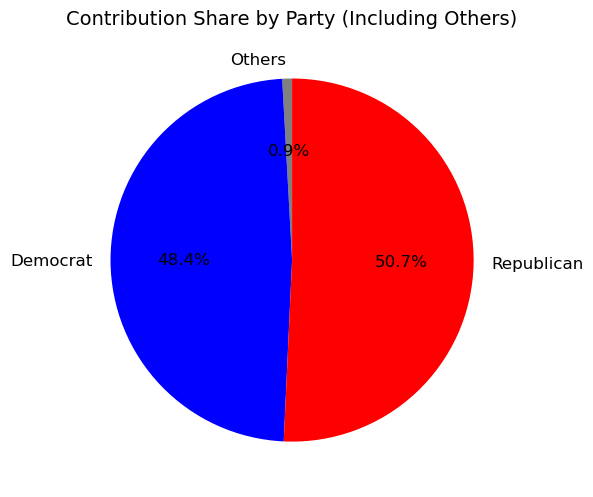

In [33]:
# Pie chart
plt.figure(figsize=(6, 6))
color_map = {
    'Republican': 'red',
    'Democrat': 'blue',
    'Others': 'gray'
}
colors = [color_map[party] for party in ConByParty_pdf['party_group']]

plt.pie(
    ConByParty_pdf['per_contr_by_party'],
    labels=ConByParty_pdf['party_group'],
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    textprops={'fontsize': 12}
)

plt.title("Contribution Share by Party (Including Others)", fontsize=14)
plt.tight_layout()
plt.show()


### Total Donations by State (in million)

In [34]:
# Convert to pandas dataframe
AggDonByState_pdf = AggDonByState_df.toPandas()
AggDonByState_pdf.head(10)

,STATE,avg_donation,total_donation_count,total_donation_in_million,percent_of_total_donation,state_name
0,CA,207.91,1221996,254.06,16.06,California
1,NY,298.13,453070,135.08,8.54,New York
2,TX,227.98,563562,128.48,8.12,Texas
3,FL,215.97,487010,105.18,6.65,Florida
4,MA,259.30,207728,53.86,3.41,Massachusetts
5,IL,239.32,224982,53.84,3.40,Illinois
6,VA,245.49,217979,53.51,3.38,Virginia
7,GA,252.87,207313,52.42,3.31,Georgia
8,WA,190.30,247707,47.14,2.98,Washington
9,MI,197.44,219649,43.37,2.74,Michigan


/tmp/ipykernel_15242/1117785287.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


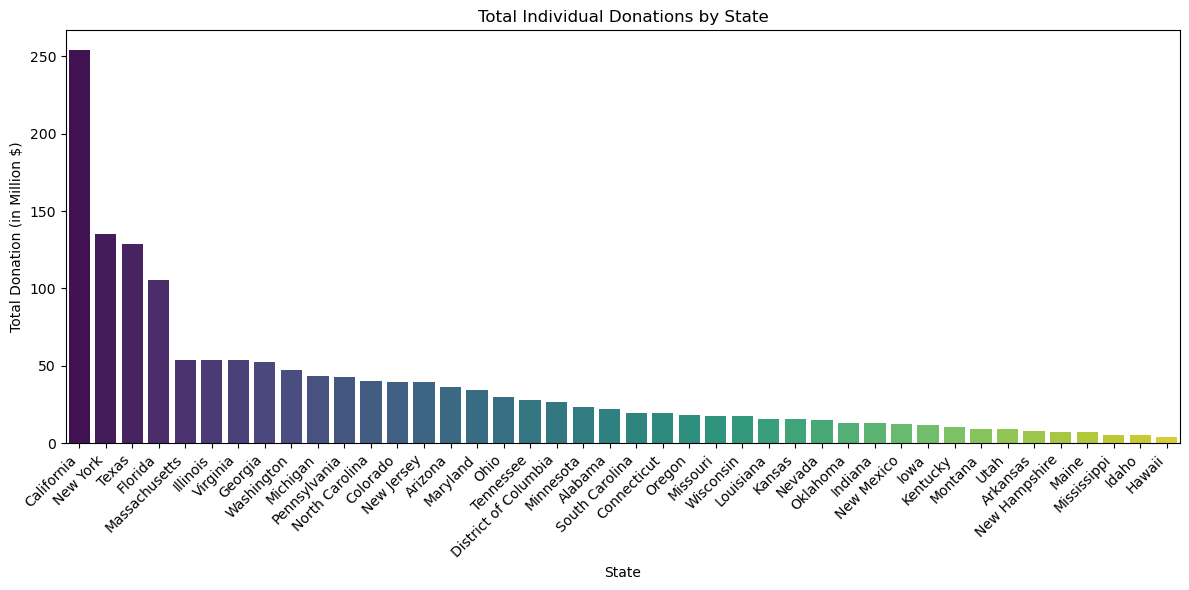

In [35]:
# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=AggDonByState_pdf,
    x='state_name',
    y='total_donation_in_million',
    palette='viridis'
)
plt.xticks(rotation=45, ha='right')

# Set axis labels and title
plt.xlabel("State")
plt.ylabel("Total Donation (in Million $)")
plt.title("Total Individual Donations by State")

plt.tight_layout()
plt.show()



### Average Donation Amount by State

/tmp/ipykernel_15242/3592284339.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


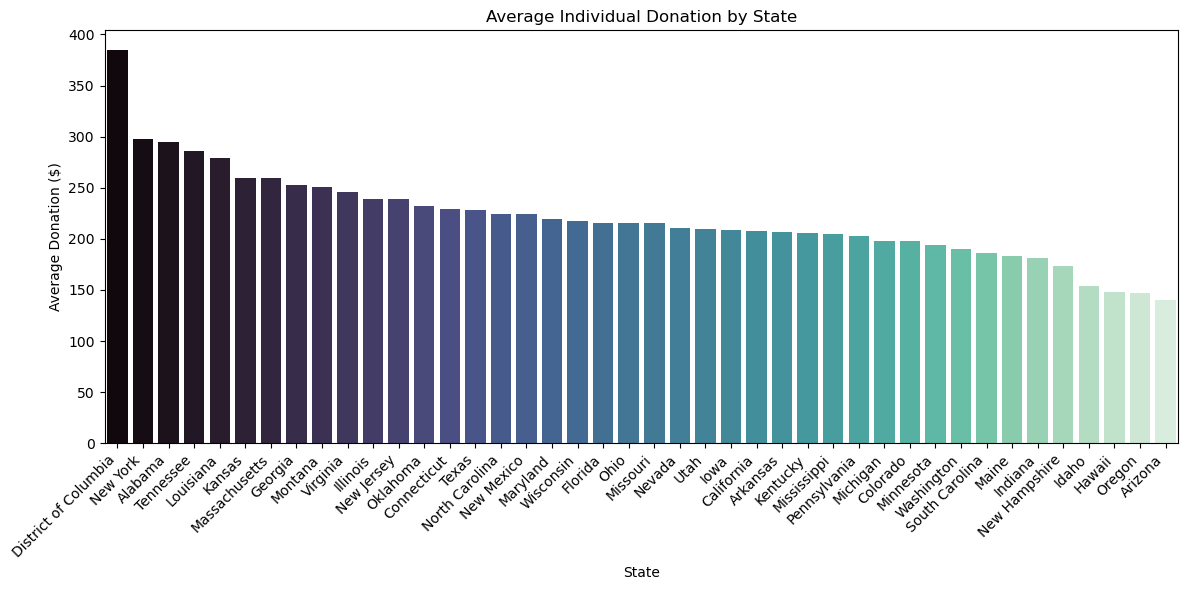

In [36]:
# Sort by average donation
AggDonByState_pdf_sorted = AggDonByState_pdf.sort_values(by='avg_donation', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=AggDonByState_pdf_sorted,
    x='state_name',
    y='avg_donation',
    palette='mako'
)
plt.xticks(rotation=45, ha='right')
plt.xlabel("State")
plt.ylabel("Average Donation ($)")
plt.title("Average Individual Donation by State")
plt.tight_layout()
plt.show()


#### % Share of Total Donations

/tmp/ipykernel_15242/4089418067.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


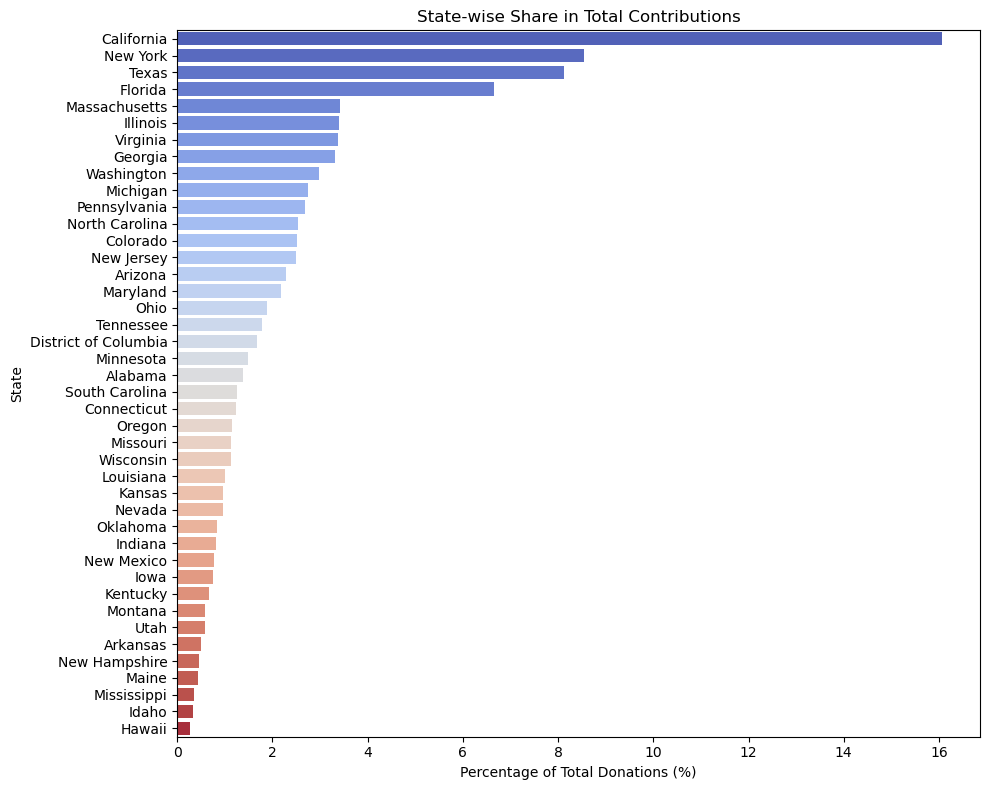

In [37]:
# Plot
plt.figure(figsize=(10, 8))
sns.barplot(
    data=AggDonByState_pdf,
    x='percent_of_total_donation',
    y='state_name',
    palette='coolwarm'
)
plt.xlabel("Percentage of Total Donations (%)")
plt.ylabel("State")
plt.title("State-wise Share in Total Contributions")
plt.tight_layout()
plt.show()


### Total Expenditure Per Month

In [38]:
# Convert to pandas df
TotExpPerMon_pdf = TotExpPerMon_df.toPandas()
TotExpPerMon_pdf

,YEAR,MONTH,total_monthly_spending_in_millions,MONTH_NAME
0,2019,1,67.84,Jan
1,2019,2,61.26,Feb
2,2019,3,68.04,Mar
3,2019,4,78.84,Apr
4,2019,5,74.49,May
5,2019,6,73.34,Jun
6,2019,7,82.90,Jul
7,2019,8,79.48,Aug
8,2019,9,87.46,Sep
9,2019,10,127.25,Oct


### Monthly Expenditure Trend Over Time

***Note:-*** We can see the expenditure peaks in October 2020.

- **October** marks the **final month before the November elections**, making it the most critical period for:
  - **TV and digital ads**
  - **Campaign rallies**
  - **Ground operations**
  - **Last-minute persuasion efforts**

- Campaigns **intensify spending to maximize voter reach** just before **Election Day (Nov 3, 2020)**.


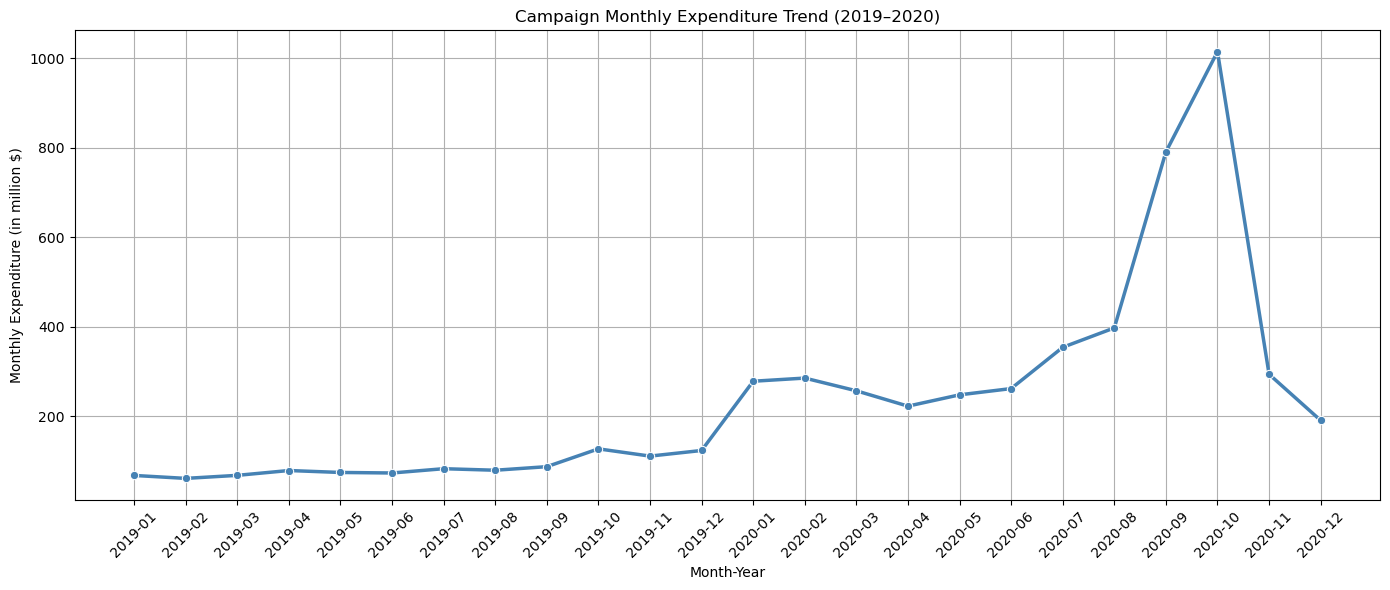

In [39]:
# Creating a Month-Year column for timeline plotting
TotExpPerMon_pdf['MONTH_YEAR'] = TotExpPerMon_pdf['YEAR'].astype(str) + "-" + TotExpPerMon_pdf['MONTH'].astype(str).str.zfill(2)

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=TotExpPerMon_pdf,
    x='MONTH_YEAR',
    y='total_monthly_spending_in_millions',
    marker='o',
    linewidth=2.5,
    color='steelblue'
)

plt.xticks(rotation=45)
plt.xlabel("Month-Year")
plt.ylabel("Monthly Expenditure (in million $)")
plt.title("Campaign Monthly Expenditure Trend (2019–2020)")
plt.tight_layout()
plt.grid(True)
plt.show()


###  Monthly Expenditure Comparison (with hue by Year)

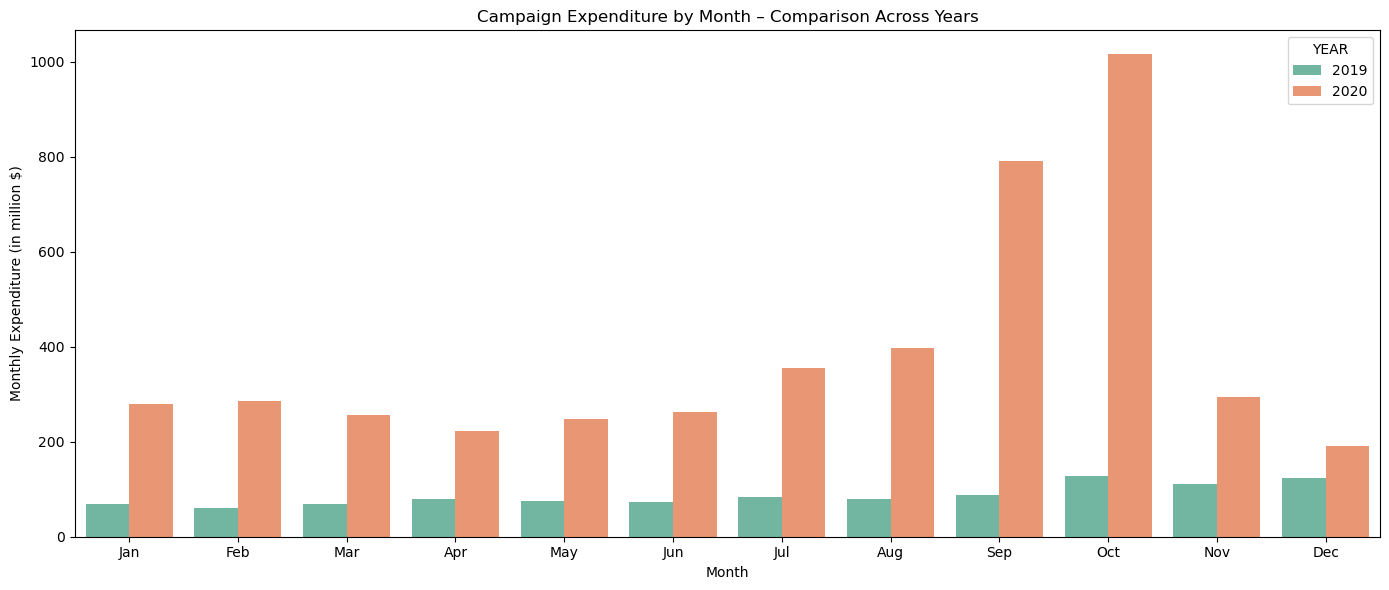

In [40]:
plt.figure(figsize=(14, 6))
sns.barplot(
    data=TotExpPerMon_pdf,
    x='MONTH_NAME',
    y='total_monthly_spending_in_millions',
    hue='YEAR',
    palette='Set2'
)

plt.xlabel("Month")
plt.ylabel("Monthly Expenditure (in million $)")
plt.title("Campaign Expenditure by Month – Comparison Across Years")
plt.tight_layout()
plt.show()


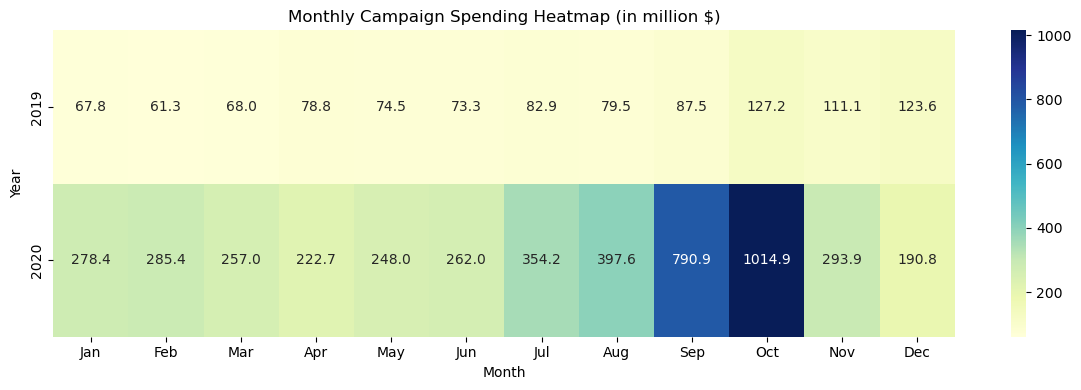

In [41]:
import pandas as pd

# Pivot for heatmap
heatmap_data = TotExpPerMon_pdf.pivot(index='YEAR', columns='MONTH_NAME', values='total_monthly_spending_in_millions')

# Ensure month order
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
heatmap_data = heatmap_data[month_order]

plt.figure(figsize=(12, 4))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu")

plt.title("Monthly Campaign Spending Heatmap (in million $)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.tight_layout()
plt.show()


### Top 20 Donors by Total Contribution

In [42]:
# Convert to pandas df
TopDonors_pdf = TopDonors_df.toPandas()
TopDonors_pdf

,NAME,total_donat_in_million,donat_freq
0,"BLOOMBERG, MICHAEL",152.92,79
1,"ADELSON, SHELDON",107.37,111
2,"ADELSON, MIRIAM",106.54,82
3,"MELLON, TIMOTHY",70.05,42
4,"STEYER, THOMAS",67.35,116
5,"UIHLEIN, RICHARD",64.96,159
6,"GRIFFIN, KENNETH",48.85,243
7,"MOSKOVITZ, DUSTIN A",46.89,9
8,"SCHWARZMAN, STEPHEN",39.76,85
9,"JURVETSON, KARLA",32.06,212


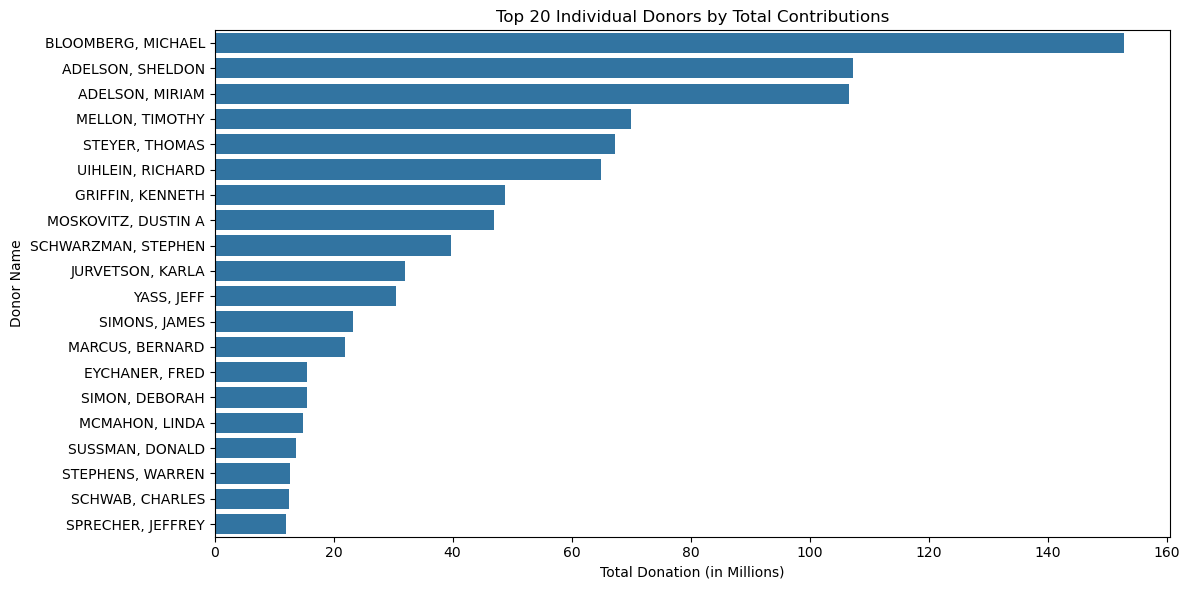

<Figure size 640x480 with 0 Axes>

In [43]:
# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='total_donat_in_million', y='NAME', data=TopDonors_pdf.head(20))

# Set axis labels and title
plt.xlabel("Total Donation (in Millions)")  # X-axis label
plt.ylabel("Donor Name")  # Y-axis label
plt.title("Top 20 Individual Donors by Total Contributions")

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()



#### Donation Distribution by Amount Bucket

In [44]:
# convert to pandas df
DonDist_pdf = DonDist_df.toPandas()
DonDist_pdf

,amount_bucket,donation_count,total_amt_in_millions
0,>10M,16,212.75
1,5M-10M,32,276.95
2,1M-5M,203,551.45
3,500K-1M,459,385.86
4,100K-500K,2829,659.48
5,50K-100K,3212,286.76
6,10K-50K,23742,643.93
7,5K-10K,40057,294.21
8,1K-5K,497355,1290.30
9,501-1K,629965,579.92


### Total Amount (in millions) by Amount Bucket

### Key Finding:
Total contributions (in dollars) are **highest** in the `101–500` and `1K–5K` donation buckets.

### Insights:

   - The `$101–500` bucket shows **massive donor participation**.
   - Suggests **average individuals** contribution surpassing **rich elite individuals**
   - **Cultivate small donors** via email and social platforms.
   - **Engage $1K–5K donors** with tailored communication/events.
   - Focus fundraising on **high-volume and high-yield buckets**.


/tmp/ipykernel_15242/3175192156.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


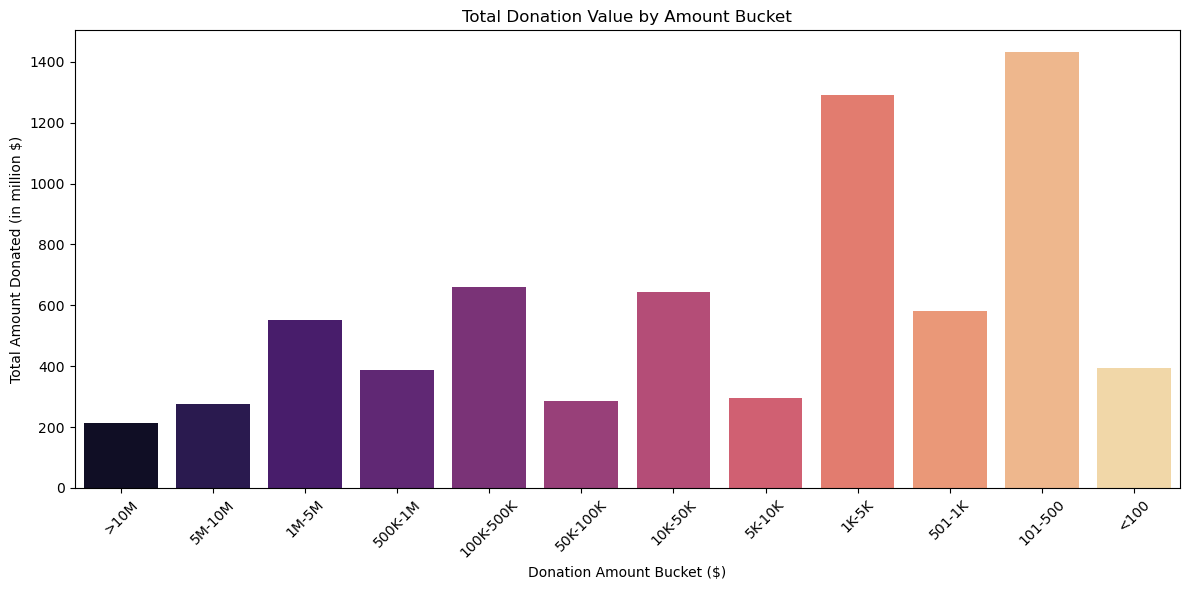

In [45]:
# plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=DonDist_pdf,
    x='amount_bucket',
    y='total_amt_in_millions',
    palette='magma'
)
plt.xticks(rotation=45)
plt.xlabel("Donation Amount Bucket ($)")
plt.ylabel("Total Amount Donated (in million $)")
plt.title("Total Donation Value by Amount Bucket")
plt.tight_layout()
plt.show()


#### Stop the spark session

In [46]:
spark.stop()